<a href="https://colab.research.google.com/github/afif-af/ml_pytorch_scikitlearn/blob/main/Chapter07ml_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [361]:
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
  k_start=int(math.ceil(n_classifier/2.))
  probs=[comb(n_classifier, k) * error **k *
          (1-error)**(n_classifier -k)
          for k in range(k_start, n_classifier +1)]
  return sum(probs)


In [362]:
ensemble_error(n_classifier=11, error=0.25)

np.float64(0.03432750701904297)

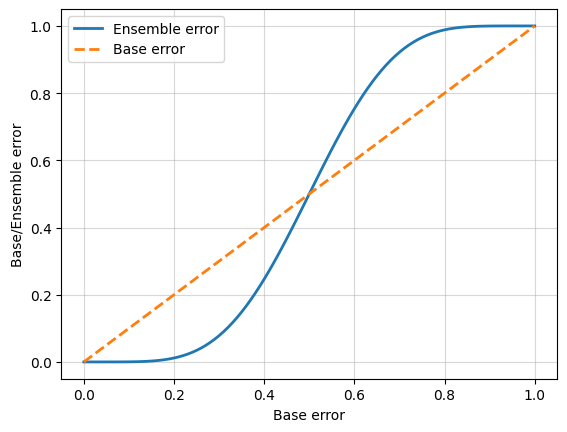

In [363]:

import numpy as np
import matplotlib.pyplot as plt
error_range=np.arange(0.0, 1.01, 0.01)
ens_errors =[ensemble_error(n_classifier=11, error=error)
             for error in error_range]
plt.plot(error_range, ens_errors, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--',label='Base error',
         linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

In [364]:
import numpy as np
np.argmax(np.bincount([0, 0, 1],
             weights=[0.2,0.2,0.6]))



np.int64(1)

In [365]:
ex=np.array([[0.9, 0.1],
             [0.8, 0.2],
             [0.4, 0.6]])
p=np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [366]:
np.argmax(p)

np.int64(0)

In [367]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {
            key: value for key,
            value in _name_estimators(classifiers)
        }
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' "
                             f"or 'classlabel' "
                             f"; got (vote={self.vote})")
        if self.weights and \
           len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and'
                             f' weights must be equal '
                             f'; got {len(self.weights)}  weights, '
                             f'{len(self.classifiers)} classifiers')
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
      if self.vote == 'probability':
        maj_vote = np.argmax(self.predict_proba(X), axis=1)
      else:
        predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
        maj_vote = np.apply_along_axis(
            lambda x: np.argmax(
              np.bincount(x, weights=self.weights)

            ),
            axis=1, arr=predictions
            )
      maj_vote = self.lablenc_.inverse_transform(maj_vote)
      return maj_vote

    def predict_proba(self, X):
        probas = np.asarray([
           clf.predict_proba(X) for clf in self.classifiers_
        ])

        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba


    # def predict_proba(self, X):
    #   probas = []
    #   for clf in self.classifiers_:
    #       proba = clf.predict_proba(X)

    #       if proba.shape[1] != len(self.classes_):
    #           # Fix class misalignment
    #           full_proba = np.zeros((X.shape[0], len(self.classes_)))
    #           for i, class_idx in enumerate(clf.classes_):
    #               class_pos = np.where(self.classes_ == class_idx)[0][0]
    #               full_proba[:, class_pos] = proba[:, i]
    #           proba = full_proba

    #       probas.append(proba)

    #   avg_proba = np.average(probas, axis=0, weights=self.weights)
    #   return avg_proba


    def get_params(self, deep=True):
      if not deep:
        return super().get_params(deep=False)
      else:
        out = self.named_classifiers.copy()
        for name, step in self.named_classifiers.items():
          for key, value in step.get_params(
              deep=True).items():
            out[f'{name}__{key}']=value

        return out

In [368]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris=datasets.load_iris()
X, y= iris.data[50:, [1,2]], iris.target[50:]
le=LabelEncoder()
y=le.fit_transform(y)


In [369]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=1,
                                                    stratify=y)

In [370]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2',
                          C=0.001,
                          random_state=1,
                          solver='lbfgs')
clf2=DecisionTreeClassifier(max_depth=1,
                            criterion='entropy',
                            random_state=0)
clf3=KNeighborsClassifier(n_neighbors=1,
                          p=2,
                          metric='minkowski')

pipe1=Pipeline([['sc', StandardScaler()],
                ['clf', clf1]])
pipe3=Pipeline([['sc', StandardScaler()],
                ['clf', clf3]])
clf_labels=['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
  scores = cross_val_score(estimator=clf,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         scoring='roc_auc')
  print(f'ROC AUC: {scores.mean():.2f}'
  f'(+/- {scores.std():.2f}) [{label}]')


10-fold cross validation:

ROC AUC: 0.92(+/- 0.15) [Logistic regression]
ROC AUC: 0.87(+/- 0.18) [Decision tree]
ROC AUC: 0.85(+/- 0.13) [KNN]


In [371]:
mv_clf = MajorityVoteClassifier(
 classifiers=[pipe1, clf2, pipe3]
 )
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f}'
          f'(+/- {scores.std():.2f}) [{label}]')

ROC AUC: 0.92(+/- 0.15) [Logistic regression]
ROC AUC: 0.87(+/- 0.18) [Decision tree]
ROC AUC: 0.85(+/- 0.13) [KNN]
ROC AUC: nan(+/- nan) [Majority voting]


In [372]:
all_clf

[Pipeline(steps=[['sc', StandardScaler()],
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 Pipeline(steps=[['sc', StandardScaler()],
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 MajorityVoteClassifier(classifiers=[Pipeline(steps=[['sc', StandardScaler()],
                                                     ['clf',
                                                      LogisticRegression(C=0.001,
                                                                         random_state=1)]]),
                                     DecisionTreeClassifier(criterion='entropy',
                                                            max_depth=1,
                                                            random_state=0),
                                     Pipeline(steps=[['sc', StandardScaler()],
                                                     ['clf',
               

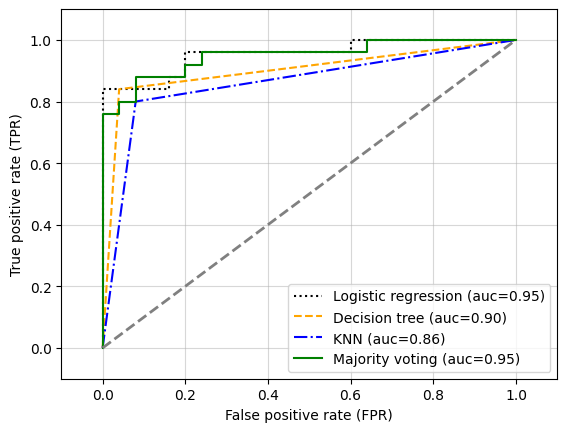

In [373]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

colors=['black','orange','blue','green']
linestyles=[':','--','-.','-']
for clf, label, clr, ls \
    in zip (all_clf, clf_labels, colors, linestyles):
    y_pred=clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
    fbr, tpr, thresholds=roc_curve(y_true=y_test,
                                   y_score=y_pred)
    roc_auc=auc(x=fbr, y=tpr)
    plt.plot(fbr, tpr,
             color=clr,
             linestyle=ls,
             label=f'{label} (auc={roc_auc:.2f})')
plt.legend(loc='lower right')
plt.plot([0,1], [0,1],
         linestyle='--',
         color='gray',
         linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()


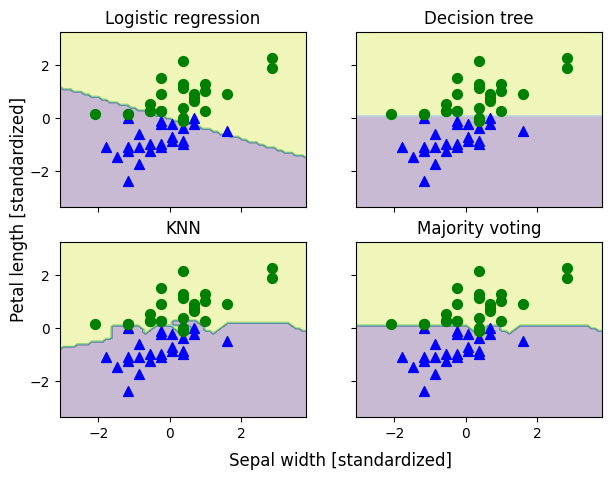

In [374]:
sc=StandardScaler()
X_train_std=sc.fit_transform(X_train)
from itertools import product
x_min=X_train_std[:, 0].min()-1
x_max=X_train_std[:, 0].max()+1
y_min=X_train_std[:, 1].min()-1
y_max=X_train_std[:, 1].max()+1

xx, yy=np.meshgrid(np.arange(x_min, x_max, 0.1),
                   np.arange(y_min, y_max, 0.1))
f, axarr=plt.subplots(nrows=2, ncols=2,
                      sharex='col',
                      sharey='row',
                      figsize=(7,5))
for idx, clf, tt in zip(product([0,1],[0,1]),
                        all_clf, clf_labels):
  clf.fit(X_train_std, y_train)
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
  axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                X_train_std[y_train==0, 1],
                                c='blue',
                                marker='^',
                                s=50)
  axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                X_train_std[y_train==1, 1],
                                c='green',
                                marker='o',
                                s=50)
  axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5, s='Sepal width [standardized]',ha='center',va='center',fontsize=12)
plt.text(-12.5, 4.5, s='Petal length [standardized]',ha='center', va='center',fontsize=12, rotation=90)
plt.show()

In [375]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__transform_input': None,
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf